In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'depths.csv', 'train.csv', 'sample_submission.csv']


In [27]:
from pylab import imread,subplot,imshow,show
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from keras.preprocessing.image import load_img
from keras.layers import Input, Activation, BatchNormalization, Add, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf

In [ ]:
%ls ../input/test/images/

# Load data

In [ ]:
depth = pd.read_csv("../input/depths.csv")
depth.head(10)

In [ ]:
depth.info()

In [ ]:
train=pd.read_csv("../input/train.csv")
train.head(10)

In [ ]:
train.info()

In [4]:
# train - only index
train = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depth = pd.read_csv("../input/depths.csv", index_col="id")
# add depth into train
train = train.join(depth)
# all index and depths are not in train
depth_others = depth[~depth.index.isin(train.index)]


In [5]:
# add info of image into train
train["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [6]:
# add value of mask into train
train["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train.index)]

In [7]:
# compute the coverage of image
img_size = 101
train["coverage"] = train.masks.map(np.sum) / (img_size** 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train["coverage_class"] = train.coverage.map(cov_to_class)

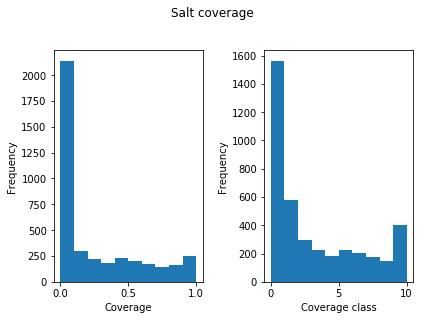

In [9]:
# Salt coverage
plt.subplot(1,2,1)
train.coverage.plot(kind='hist')
plt.xlabel('Coverage')

plt.subplot(1,2,2)
train.coverage_class.plot(kind='hist')
plt.xlabel('Coverage class')

plt.suptitle('Salt coverage',y=1.1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Depth distribution')

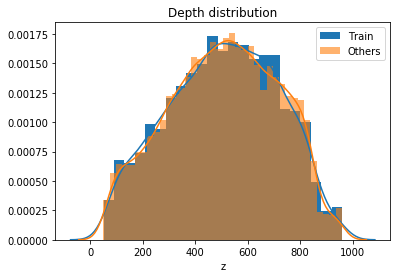

In [10]:
# Depth distributions¶
sns.distplot(train.z, label="Train",hist_kws=dict(alpha=1))
sns.distplot(depth_others.z, label="Others",hist_kws=dict(alpha=0.6))
plt.legend()
plt.title("Depth distribution")

In [11]:
def upsample(img):    
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

In [13]:
# train/validation split
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train.index.values,
    np.array(train.images.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    np.array(train.masks.map(upsample).tolist()).reshape(-1, img_size, img_size, 1), 
    train.coverage.values,
    train.z.values,
    test_size=0.3, stratify=train.coverage_class, random_state= 1)

In [14]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation('relu')(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [15]:
# Model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    # 12 -> 25    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 50 -> 101    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [16]:
#Score the model 
# from: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)    
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

In [17]:
x_train_1 = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train_1 = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train_1.shape)
print(y_valid.shape)

(5600, 101, 101, 1)
(1200, 101, 101, 1)


In [18]:
# model
input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16, 0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [21]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)

epochs = 20
batch_size = 32

history = model.fit(x_train_1, y_train_1,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

Train on 5600 samples, validate on 1200 samples
Epoch 1/20
 - 87s - loss: 0.1588 - my_iou_metric: 0.6738 - val_loss: 0.1464 - val_my_iou_metric: 0.7348

Epoch 00001: val_my_iou_metric improved from -inf to 0.73475, saving model to ./unet_best1.model
Epoch 2/20
 - 86s - loss: 0.1562 - my_iou_metric: 0.6755 - val_loss: 0.3053 - val_my_iou_metric: 0.5985

Epoch 00002: val_my_iou_metric did not improve from 0.73475
Epoch 3/20
 - 86s - loss: 0.1569 - my_iou_metric: 0.6726 - val_loss: 0.1670 - val_my_iou_metric: 0.6781

Epoch 00003: val_my_iou_metric did not improve from 0.73475
Epoch 4/20
 - 86s - loss: 0.1706 - my_iou_metric: 0.6566 - val_loss: 0.5600 - val_my_iou_metric: 0.5208

Epoch 00004: val_my_iou_metric did not improve from 0.73475
Epoch 5/20
 - 86s - loss: 0.1531 - my_iou_metric: 0.6805 - val_loss: 0.1494 - val_my_iou_metric: 0.7308

Epoch 00005: val_my_iou_metric did not improve from 0.73475
Epoch 6/20
 - 86s - loss: 0.1528 - my_iou_metric: 0.6938 - val_loss: 0.2130 - val_my_iou_m

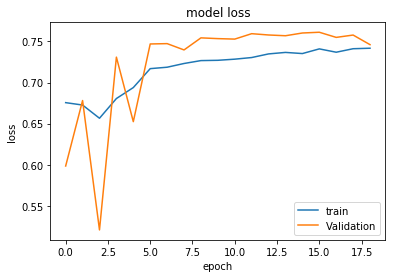

In [22]:
# history for loss
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='best')
plt.show()

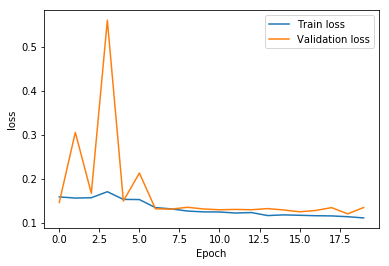

In [25]:
#fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Validation loss")
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [28]:
model = load_model("./unet_best1.model",custom_objects={'my_iou_metric': my_iou_metric})

In [29]:
def predict_result(model,x_test,img_size_target): 
    # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size, img_size)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size, img_size)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 + preds_test2)/2
    return preds_avg

In [30]:
def downsample(img):
    return resize(img, (img_size, img_size), mode='constant', preserve_range=True)

preds_valid = predict_result(model,x_valid,img_size)
preds_valid2 = np.array([downsample(x) for x in preds_valid])

y_valid2 = np.array([downsample(x) for x in y_valid])

In [31]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])

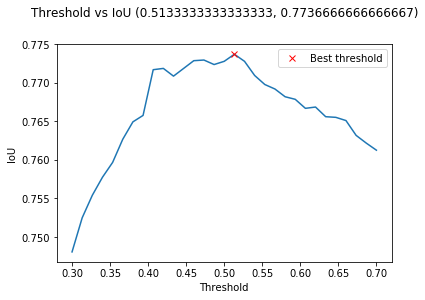

In [37]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best),y=1.1)
plt.legend()

In [33]:
def rle_encode(im):
    """
    used for converting the decoded image to rle mask
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [34]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(depth_others.index)]).reshape(-1, img_size, img_size, 1)

In [36]:
preds_test = predict_result(model,x_test,img_size)

In [39]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(depth_others.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 38.60549521446228 s


In [40]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [41]:
%ls

__notebook_source__.ipynb  submission.csv  unet_best1.model


# Look at some figures

In [ ]:
x = 6 #np.random.randint(0,len(train))
print('Index of figure',x)
plt.figure(figsize=(20,10))
image = imread('../input/train/images/'+train.id[x]+'.png')  # choose image location
image_mask = imread('../input/train/masks/'+train.id[x]+'.png')
plt.subplot(2,1,1)
plt.imshow(image)

plt.subplot(2,1,2)
plt.imshow(image_mask,cmap='gray')

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

Image without salt, its mark is dark.

In [ ]:
train.iloc[x,:]

In [ ]:
depth[depth.id == train.iloc[x,0]]

In [ ]:
len(train.id.unique())

In [ ]:
len(depth.id.unique())

In [ ]:
x1=depth.id[0] 
for i in train.id:
    if i==x1:
        print(i)
        print('True')


In [ ]:
type(train['rle_mask'][7])

In [ ]:
train.rle_mask.apply(lambda x: x=='nan')